In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from keras.models import Sequential
from keras.layers import LSTM, Dense
import matplotlib.pyplot as plt

In [2]:
inflation = pd.read_csv('/content/Inflation_only.csv')
inflation

,Month,CPI
0,Jan.1972,95.8
1,Feb.1972,96.6
2,Mar.1972,97.2
3,Apr.1972,98.8
4,May.1972,99.5
...,...,...
619,Aug.2023,892.2
620,Sep.2023,898.5
621,Oct.2023,901.0
622,Nov.2023,898.0


In [3]:
inflation['Month'] = pd.to_datetime(inflation['Month'], format='%b.%Y')
inflation.set_index('Month', inplace=True)

#### Select CPI as the target

In [4]:
y = inflation['CPI']

In [5]:
y_values = y.values.reshape(-1, 1)

scaler = MinMaxScaler(feature_range=(0, 1))
y_scaled = scaler.fit_transform(y_values)

#### Taking the 12 months from the final year for testing and using the rest for training

In [6]:
test_months = 12
train_data = y_scaled[:-test_months]
test_data = y_scaled[-test_months:]

In [7]:
sequence_length = 12
data_train, target_train = [], []

for i in range(len(train_data) - sequence_length):
    data_train.append(train_data[i:i+sequence_length])
    target_train.append(train_data[i+sequence_length])

In [8]:
data_train = np.array(data_train)
target_train = np.array(target_train)

data_train = np.reshape(data_train, (data_train.shape[0], data_train.shape[1], 1))


#### Building a 3 LSTM Model for training the dataset

In [9]:
model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(data_train.shape[1], 1)))
model.add(LSTM(units=50, return_sequences=True))
model.add(LSTM(units=50))
model.add(Dense(units=1))

model.compile(optimizer='adam', loss='mean_squared_error')

In [10]:
model.fit(data_train, target_train, epochs=50, batch_size=64)

Epoch 1/50
10/10 [==============================] - 14s 60ms/step - loss: 0.1199
Epoch 2/50
10/10 [==============================] - 1s 64ms/step - loss: 0.0221
Epoch 3/50
10/10 [==============================] - 1s 73ms/step - loss: 0.0111
Epoch 4/50
10/10 [==============================] - 1s 64ms/step - loss: 0.0057
Epoch 5/50
10/10 [==============================] - 1s 81ms/step - loss: 0.0021
Epoch 6/50
10/10 [==============================] - 1s 54ms/step - loss: 6.2629e-04
Epoch 7/50
10/10 [==============================] - 1s 94ms/step - loss: 1.9547e-04
Epoch 8/50
10/10 [==============================] - 1s 63ms/step - loss: 1.6401e-04
Epoch 9/50
10/10 [==============================] - 1s 77ms/step - loss: 1.3930e-04
Epoch 10/50
10/10 [==============================] - 1s 54ms/step - loss: 1.1840e-04
Epoch 11/50
10/10 [==============================] - 1s 51ms/step - loss: 1.0389e-04
Epoch 12/50
10/10 [==============================] - 0s 46ms/step - loss: 1.0474e-04
Epoch 13

#### Creating prediction and adding it to the model to make additional prediction with 12 input layers

In [11]:
predictions = []
current_sequence = y_scaled[-12:]

# Number of steps to predict
num_steps = 12

for _ in range(num_steps):

    current_sequence_reshaped = current_sequence.reshape(1, sequence_length, 1)
    predicted_value_scaled = model.predict(current_sequence_reshaped)
    predicted_value = predicted_value_scaled.reshape(1, -1).flatten()[0]
    predictions.append(predicted_value)
    current_sequence = np.concatenate((current_sequence[1:], [[predicted_value]]))

1/1 [==============================] - 0s 22ms/step


#### Scaling back the test data and predictions to true values

In [12]:
actual_values = test_data

In [13]:
actual_values = scaler.inverse_transform(y_scaled[-num_steps:]).flatten()

In [14]:
predictions = [scaler.inverse_transform(np.array(pred).reshape(1, -1)).flatten()[0] for pred in predictions]

In [15]:
predictions = predictions[::-1]
predictions

[904.9904,
 904.452,
 904.2705,
 903.9381,
 903.0682,
 902.8556,
 902.28925,
 901.5961,
 900.702,
 899.5492,
 897.8403,
 895.39935]

In [16]:
actual_values

array([874.1, 881.4, 887.1, 889.9, 892.3, 894.1, 898.6, 892.2, 898.5,
       901. , 898. , 900.4])

#### Plotting the true values

<Figure size 1000x600 with 0 Axes>

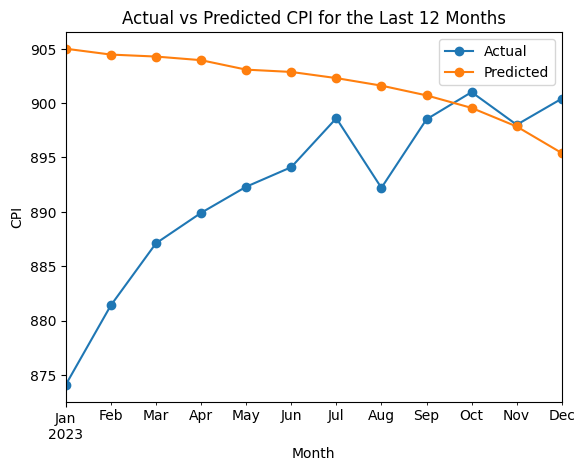

In [17]:
df_plot = pd.DataFrame({'Actual': actual_values, 'Predicted': predictions}, index=y.index[-num_steps:])

# Plotting
plt.figure(figsize=(10, 6))
df_plot.plot(marker='o')
plt.title('Actual vs Predicted CPI for the Last 12 Months')
plt.xlabel('Month')
plt.ylabel('CPI')
plt.legend(['Actual', 'Predicted'])
plt.show()

Accuracy of the models on the true value

In [18]:

mse = mean_squared_error(actual_values, predictions)
print(f'Mean Squared Error (MSE): {mse}')

rmse = np.sqrt(mse)
print(f'Root Mean Squared Error (RMSE): {rmse}')

r2 = r2_score(actual_values, predictions)
print(f'R-squared: {r2}')

Mean Squared Error (MSE): 192.00051859182625
Root Mean Squared Error (RMSE): 13.856425173609038
R-squared: -2.121875048239779


In [19]:

predictions = []
current_sequence = y_scaled[-12:]

# Number of steps to predict
num_steps = 12

for i in range(num_steps):
    # Predict the next value
    current_sequence_reshaped = current_sequence.reshape(1, sequence_length, 1)
    predicted_value_scaled = model.predict(current_sequence_reshaped)
    predicted_value = predicted_value_scaled.flatten()[0]

    # Append the predicted value to predictions
    predictions.append(predicted_value)

    # Get the actual value from test_data
    actual_value_scaled = test_data[i]
    actual_value = actual_value_scaled.flatten()[0]

    # Update the current_sequence with actual value
    current_sequence = np.concatenate((current_sequence[1:], [[actual_value]]))

# Flatten test_data and get the first num_steps values
actual_values = test_data[:num_steps].flatten()

# Append the predictions and actual values to the predictions table
predictions_table = pd.DataFrame({'Predicted': predictions, 'Actual': actual_values})


1/1 [==============================] - 0s 23ms/step


In [20]:
predictions = [scaler.inverse_transform(np.array(pred).reshape(1, -1)).flatten()[0] for pred in predictions]

In [21]:
actual_values = scaler.inverse_transform(y_scaled[-num_steps:]).flatten()

In [22]:
predictions_table = pd.DataFrame({'Predicted': predictions, 'Actual': actual_values})
predictions_table

,Predicted,Actual
0,895.399353,874.1
1,897.619690,881.4
2,898.823914,887.1
3,899.209778,889.9
4,899.129150,892.3
5,898.711121,894.1
6,898.104492,898.6
7,897.182068,892.2
8,896.956604,898.5
9,896.293884,901.0


<Figure size 1000x600 with 0 Axes>

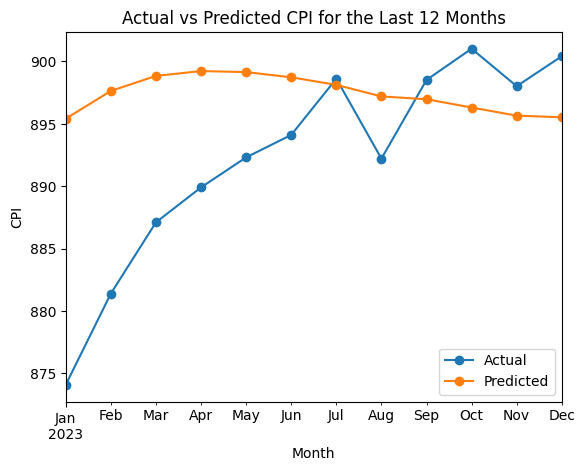

In [23]:
df_plot = pd.DataFrame({'Actual': actual_values, 'Predicted': predictions}, index=y.index[-num_steps:])

# Plotting
plt.figure(figsize=(10, 6))
df_plot.plot(marker='o')
plt.title('Actual vs Predicted CPI for the Last 12 Months')
plt.xlabel('Month')
plt.ylabel('CPI')
plt.legend(['Actual', 'Predicted'])
plt.show()

In [24]:

mse = mean_squared_error(actual_values, predictions)
print(f'Mean Squared Error (MSE): {mse}')

rmse = np.sqrt(mse)
print(f'Root Mean Squared Error (RMSE): {rmse}')

r2 = r2_score(actual_values, predictions)
print(f'R-squared: {r2}')

Mean Squared Error (MSE): 90.65204004645337
Root Mean Squared Error (RMSE): 9.521136489225084
R-squared: -0.4739769661492148
